# Introduction to CREsted

In this introductory notebook, we will train a peak regression model and inspect the results to get a feel for the capabilities of the CREsted package.  
For an in depth analysis of the mouse BICCN dataset, please refer to the [Mouse BICCN notebook](mouse_biccn.ipynb).

## Import Data

In [1]:
import crested
import os

os.environ["CRESTED_DATA_DIR"] = "../../../Crested_testing/data/tmp"

In [3]:
# download the data
bigwigs_folder, regions_file = crested.get_dataset("mouse_cortex_bigwig")

We can use the {func}`~crested.import_bigwigs` function to import bigwigs per cell type and a consensus regions BED file into an {class}`anndata.AnnData` object,
with the imported cell types as the `AnnData.obs` and the consensus peak regions as the `AnnData.var`.  

Optionally, provide a chromsizes file to filter out regions that are not within the chromsizes. 

In [29]:
adata = crested.import_bigwigs(
    bigwigs_folder=bigwigs_folder,
    regions_file=regions_file,
    target_region_width=1000,  # optionally, use a different width than the regions file (500bp) for the .X values calculation
    target="mean",
)
adata

2024-07-04T16:37:46.941946+0200 WARNING Chromsizes file not provided. Will not check if regions are within chromosomes
2024-07-04T16:37:53.154110+0200 INFO Extracting values from 19 bigWig files...


AnnData object with n_obs × n_vars = 19 × 546993
    obs: 'file_path'
    var: 'chr', 'start', 'end'

To train a model, we'll need to add a *split* column to our dataset, which we can do using {func}`~crested.pp.train_val_test_split`.  
This will add a column to the `AnnData.obs` with the split type for each region.

In [30]:
# Choose the chromosomes for the validation and test sets
crested.pp.train_val_test_split(
    adata, strategy="chr", val_chroms=["chr8", "chr10"], test_chroms=["chr9", "chr18"]
)

# Alternatively, We can split randomly on the regions
# crested.pp.train_val_test_split(
#     adata, strategy="region", val_size=0.1, test_size=0.1, random_state=42
# )

print(adata.var["split"].value_counts())
adata.var

split
train    440993
val       56064
test      49936
Name: count, dtype: int64


,chr,start,end,split
region,,,,
chr1:3094805-3095305,chr1,3094805,3095305,train
chr1:3095470-3095970,chr1,3095470,3095970,train
chr1:3112174-3112674,chr1,3112174,3112674,train
chr1:3113534-3114034,chr1,3113534,3114034,train
chr1:3119746-3120246,chr1,3119746,3120246,train
...,...,...,...,...
chrX:169879313-169879813,chrX,169879313,169879813,train
chrX:169880181-169880681,chrX,169880181,169880681,train
chrX:169925477-169925977,chrX,169925477,169925977,train


For this example we're interested in training on wider regions that our consensus regions file (500bp) to also include some sequence information from the flanking regions.  

In [31]:
crested.pp.change_regions_width(
    adata, 2114
)  # change the width of the regions to 2114bp

2024-07-04T16:38:31.293726+0200 WARNING Chromsizes file not provided. Will not check if regions are within chromosomes


## Fit and Evaluate

The entire CREsted workflow is built around the {func}`~crested.tl.Crested` class.
Everything that requires a model (training, evaluation, prediction) is done through this class.  
This class has a couple of required arguments:
- `data`: the {class}`~crested.tl.data.AnnDataModule` object containing all the data (anndata, genome) and dataloaders that specify how to load the data.
- `model`: the {class}`~tf.keras.Model` object containing the model architecture.
- `config`: the {class}`~crested.tl.TaskConfig` object containing the optimizer, loss function, and metrics to use in training.

### Data

We'll start by initializing the {class}`~crested.tl.data.AnnDataModule` object with our data.  
This will tell our model how to load the data and what data to load during fitting/evaluation.
The main arguments to suuply are the `adata` object, the `genome` object, and the `batch_size`.  
Other optional arguments are related to the training data loading (e.g. shuffling, whether to load the sequences into memory, ...)

In [15]:
datamodule = crested.tl.data.AnnDataModule(
    adata,
    genome_file="/staging/leuven/res_00001/genomes/10xgenomics/CellRangerARC/refdata-cellranger-arc-mm10-2020-A-2.0.0/fasta/genome.fa",
    batch_size=256,
    max_stochastic_shift=3,  # optional augmentation
    always_reverse_complement=True,  # default True
)

2024-07-04T16:21:11.104679+0200 WARNING Chromsizes file not provided when shifting. Will not check if shifted regions are within chromosomes


### Model definition 

Next, we'll define the model architecture. This is a standard Keras model definition, so you can provide any model you like.
Altneratively, there are a couple of ready-to-use models available in the `crested.tl.zoo` module.
Each of them require the width of the input sequences and the number of output classes (your `Anndata.obs`) as arguments.

For example, to use the architecture that was used to train the deepMEL, etc models, you can load the {func}`~crested.tl.zoo.deeptopic_cnn` model.

In [16]:
# Load deeptopic_cnn architecture for a dataset with 2114bp regions and 19 cell types
from crested.tl.zoo import chrombpnet

model_architecture = chrombpnet(seq_len=2114, num_classes=19)

### TaskConfig

The TaskConfig object specifies the optimizer, loss function, and metrics to use in training (we call this our 'task').  
Some default configurations are available for some common tasks such as 'topic_classification' and 'peak_regression',
which you can load using the {func}`~crested.tl.default_configs` function.  

In [18]:
# Load the default configuration for training a topic classication model
from crested.tl import default_configs, TaskConfig

config = default_configs("peak_regression")
print(config)

# If you want to change some small parameters to an existing config, you can do it like this
# For example, the default learning rate is 0.001, but you can change it to 0.0001
# config.optimizer.learning_rate = 0.0001

TaskConfig(optimizer=<keras.src.backend.torch.optimizers.torch_adam.Adam object at 0x149b8a64d700>, loss=<crested.tl.losses._cosinemse.CosineMSELoss object at 0x149b8a64d670>, metrics=[<MeanAbsoluteError name=mean_absolute_error>, <MeanSquaredError name=mean_squared_error>, <CosineSimilarity name=cosine_similarity>, <PearsonCorrelation name=pearson_correlation>, <ConcordanceCorrelationCoefficient name=concordance_correlation_coefficient>, <PearsonCorrelationLog name=pearson_correlation_log>, <ZeroPenaltyMetric name=zero_penalty_metric>])


Alternatively, you can create your own TaskConfig object and specify the optimizer, loss function, and metrics yourself if you want to do something completely custom.

In [20]:
# Create your own configuration
import keras

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
loss = keras.losses.BinaryCrossentropy(from_logits=False)
metrics = [
    keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
    )
]
alternative_config = TaskConfig(optimizer, loss, metrics)
print(alternative_config)

TaskConfig(optimizer=<keras.src.backend.torch.optimizers.torch_adam.Adam object at 0x149b8a64ce30>, loss=<keras.src.losses.losses.BinaryCrossentropy object at 0x149b8a64c5f0>, metrics=[<AUC name=auc>])


### Training

Now we're ready to train our model.
We'll create a {class}`~crested.tl.Crested` object with the data, model, and config objects we just created.  
Then, we can call the {meth}`~crested.tl.Crested.fit` method to train the model.  
Read the documentation for more information on all available arguments to customize your training (e.g. augmentations, early stopping, ...).

In [23]:
# setup the trainer
trainer = crested.tl.Crested(
    data=datamodule,
    model=model_architecture,
    config=config,
    project_name="mouse_biccn",
    logger=None,  # wandb, tensorboard
)

In [24]:
# train the model
trainer.fit(epochs=50)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 2114, 4)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2114, 512) │     10,240 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2114, 512) │      2,048 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2114, 512) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2114, 512) │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1conv         │ (None, 2110, 512) │    786,432 │ dropout[0][0]     │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1bn           │ (None, 2110, 512) │      2,048 │ bpnet_1conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1activation   │ (None, 2110, 512) │          0 │ bpnet_1bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1crop         │ (None, 2110, 512) │          0 │ dropout[0][0]     │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2110, 512) │          0 │ bpnet_1activatio… │
│                     │                   │            │ bpnet_1crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_1dropout      │ (None, 2110, 512) │          0 │ add[0][0]         │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2conv         │ (None, 2102, 512) │    786,432 │ bpnet_1dropout[0… │
│ (Conv1D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2bn           │ (None, 2102, 512) │      2,048 │ bpnet_2conv[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2activation   │ (None, 2102, 512) │          0 │ bpnet_2bn[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2crop         │ (None, 2102, 512) │          0 │ bpnet_1dropout[0… │
│ (Cropping1D)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2102, 512) │          0 │ bpnet_2activatio… │
│                     │                   │            │ bpnet_2crop[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bpnet_2dropout      │ (None, 2102, 512) │          0 │ add_1[0][0]       │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,329,875 (24.15 MB)

 Trainable params: 6,320,659 (24.11 MB)

 Non-trainable params: 9,216 (36.00 KB)

None
2024-07-04T16:23:35.774664+0200 INFO Loading sequences into memory...


100%|██████████| 440993/440993 [00:13<00:00, 31752.75it/s]


2024-07-04T16:23:50.088883+0200 INFO Loading sequences into memory...


100%|██████████| 56064/56064 [00:01<00:00, 43273.82it/s]


Epoch 1/50
  28/3446 ━━━━━━━━━━━━━━━━━━━━ 36:03 633ms/step - concordance_correlation_coefficient: 0.0793 - cosine_similarity: 0.5090 - loss: 0.4266 - mean_absolute_error: 0.4107 - mean_squared_error: 0.8432 - pearson_correlation: 0.0903 - pearson_correlation_log: 0.0655 - zero_penalty_metric: 1387.28532024-07-04T16:25:12.873805+0200 WARNING Training interrupted by user.


## Evaluate the model

After training, we can evaluate the model on the test set using the {meth}`~crested.tl.Crested.test` method.  
If we're still in the same session, we can simply continue using the same object.  
If not, we can load the model from disk using the {func}`~crested.tl.Crested.load_model` method.
This means that we have to create a new {class}`~crested.tl.Crested` object first.  
However, this time, since the taskconfig and architecture are saved in the .keras file, we only have to provide our data.

In [25]:
evaluator = crested.tl.Crested(data=datamodule)

# load an existing model
evaluator.load_model(
    "../../../Crested_testing/mouse_biccn/2024-07-04_10:43/checkpoints/08.keras"
)

In [26]:
# evaluate the model on the test set
evaluator.test()

196/196 ━━━━━━━━━━━━━━━━━━━━ 29s 148ms/step - concordance_correlation_coefficient: 0.7825 - cosine_similarity: 0.8476 - loss: -0.7410 - mean_absolute_error: 0.1631 - mean_squared_error: 0.0772 - pearson_correlation: 0.7913 - pearson_correlation_log: 0.4612 - zero_penalty_metric: 974.7362
2024-07-04T16:27:21.210306+0200 INFO Test concordance_correlation_coefficient: 0.7786
2024-07-04T16:27:21.210854+0200 INFO Test cosine_similarity: 0.8514
2024-07-04T16:27:21.211189+0200 INFO Test loss: -0.7432
2024-07-04T16:27:21.211492+0200 INFO Test mean_absolute_error: 0.1654
2024-07-04T16:27:21.211774+0200 INFO Test mean_squared_error: 0.0787
2024-07-04T16:27:21.212034+0200 INFO Test pearson_correlation: 0.7865
2024-07-04T16:27:21.212327+0200 INFO Test pearson_correlation_log: 0.4633
2024-07-04T16:27:21.212603+0200 INFO Test zero_penalty_metric: 872.0504


## Predict

After training, we can also use the {meth}`~crested.tl.Crested.predict` method to predict the labels for new data and add them as a layer to the `AnnData` object.  
A common use case is to compare the predicted labels to the true labels for multiple trained models to see how well they compare.  

We can initiate a new Crested object (if you have different data) or use the existing one.  
Here we continue with the existing one since we'll use the same data as we trained on.

In [32]:
# add predictions for model 1 to the adata
evaluator.load_model(
    "../../../Crested_testing/mouse_biccn/2024-07-04_10:43/checkpoints/08.keras"
)
evaluator.predict(
    adata, model_name="checkpoint_08"
)  # adds the predictions to the adata.layers["checkpoint_08"]

# add predictions for model 2 to the adata
evaluator.load_model(
    "../../../Crested_testing/mouse_biccn/2024-07-04_10:43/checkpoints/04.keras"
)
evaluator.predict(
    adata, model_name="checkpoint_04"
)  # adds the predictions to the adata.layers["checkpoint_04"]

2137/2137 ━━━━━━━━━━━━━━━━━━━━ 259s 121ms/step
2024-07-04T16:43:01.430467+0200 INFO Adding predictions to anndata.layers[checkpoint_08].
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 259s 121ms/step
2024-07-04T16:47:20.521200+0200 INFO Adding predictions to anndata.layers[checkpoint_04].


array([[0.01071361, 0.07740116, 0.04164283, ..., 0.19651087, 0.04815681,
        0.08590212],
       [0.0071993 , 0.07507218, 0.0457896 , ..., 0.12058992, 0.03906372,
        0.05554185],
       [0.04091752, 0.18081212, 0.03086154, ..., 0.17445913, 0.1414657 ,
        0.19481894],
       ...,
       [0.09192368, 0.14067818, 0.03197403, ..., 0.15341729, 0.13929233,
        0.1932358 ],
       [0.00904558, 0.17962539, 0.12386874, ..., 0.11279046, 0.09334813,
        0.03018724],
       [0.02117039, 0.11848136, 0.02639035, ..., 0.10787693, 0.09820927,
        0.09786328]], dtype=float32)

Many of the plotting functions in the `crested.pl` module can be used to visualize the results of the model.

## Contribution Scores

We can calculate the contribution scores for a **sequence** of interest using the {meth}`~crested.tl.Crested.calculate_contribution_scores_sequence` method.

In [36]:
# random sequence of length 2114bp as an example
sequence = "A" * 2114

scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores_sequence(
    sequence, class_names=["Astro", "Endo"]
)  # focus on two cell types of interest

['Astro', 'Endo']
2024-07-04T16:52:41.411029+0200 INFO Calculating contribution scores for 2 class(es) and 1 region(s).


Region:   0%|          | 0/1 [00:00<?, ?it/s]/lustre1/project/stg_00002/lcb/lmahieu/projects/CREsted/src/crested/tl/_explainer_torch.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, requires_grad=True)
Region: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]


Alternatively, you can calculate contribution scores for **regions** of interest using the {meth}`~crested.tl.Crested.calculate_contribution_scores_regions` method.  
These regions don't have to be in your original dataset, as long as they exist in the genome file that you provided to the `AnnDataModule`.

In [40]:
# focus on two cell types of interest
scores, one_hot_encoded_sequences = evaluator.calculate_contribution_scores_regions(
    ["chr1:3093998-3096112", "chr1:3094664-3096778"], class_names=["Astro", "Endo"]
)

['Astro', 'Endo']
2024-07-04T16:56:41.461708+0200 INFO Calculating contribution scores for 2 class(es) and 2 region(s).


Region:   0%|          | 0/2 [00:00<?, ?it/s]/lustre1/project/stg_00002/lcb/lmahieu/projects/CREsted/src/crested/tl/_explainer_torch.py:98: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, requires_grad=True)
Region: 100%|██████████| 2/2 [00:04<00:00,  2.38s/it]


Contribution scores for regions can be plotted using the {func}`~crested.pl.patterns.contribution_scores` function.  
Will generate a plot per region.

2024-07-04T17:01:14.554923+0200 INFO Plotting contribution scores for 2 sequence(s)


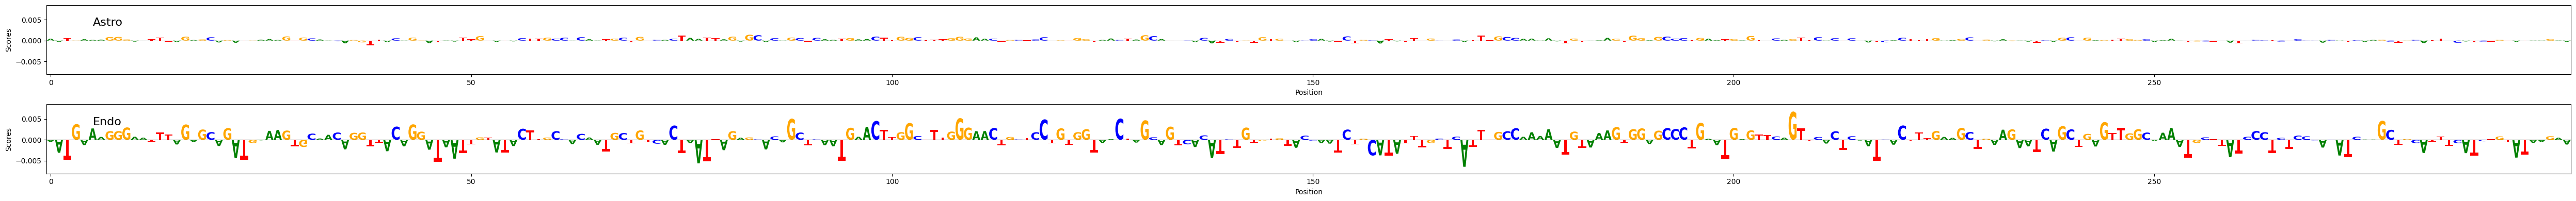

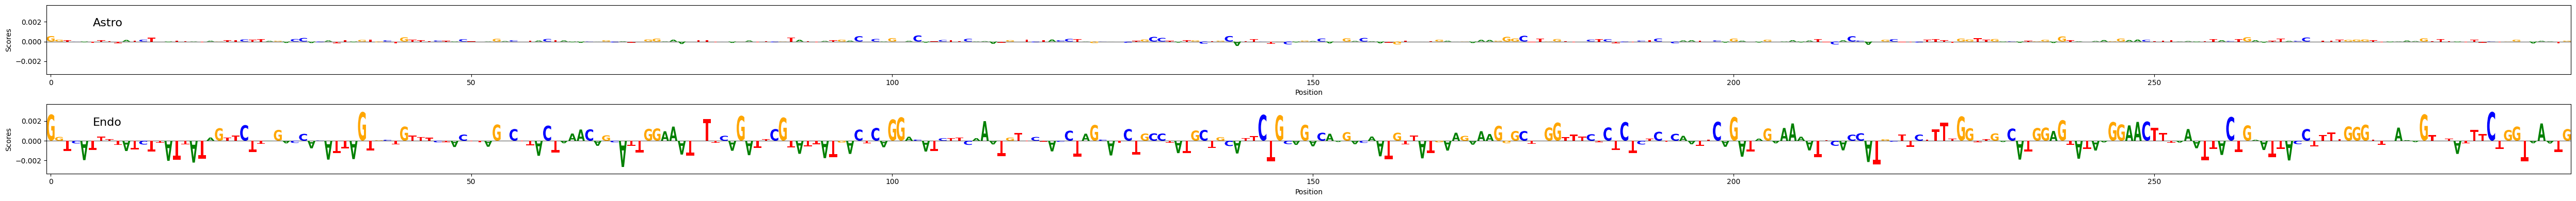

In [44]:
%matplotlib inline
crested.pl.patterns.contribution_scores(
    scores, one_hot_encoded_sequences, labels=["Astro", "Endo"], zoom_n_bases=300
)  # zoom in on the center 300bp

## Sequence evolution

We can create synthetic enhancers for a specified class using in silico evolution with the {meth}`~crested.tl.Crested.enhancer_design_in_silico_evolution` method.

In [ ]:
evaluator.enhancer_design_in_silico_evolution(
    target_class="Astro", n_sequences=1, n_mutations=25
)

## Plotting

There is a bunch of plotting functions available in the `crested.pl` module to visualize the results of the model.
We will show some examples below, but refer to the documentation for more information.

### Inspecting regions of interest using bar plots